In [10]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from collections import deque
import random
seed = 123

## FUNCTION FROM CHAT GPT
def create_maze(size, seed=None):
    if seed is not None:
        random.seed(seed)
    
    maze = [[2] * (size + 2) for _ in range(size + 2)]  # Initialize maze with all walls
    
    # Create an open space in the center
    center = size // 2
    maze[center + 1][center + 1] = 0
    
    # Recursive backtracking algorithm to generate the maze
    def generate(x, y):
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        random.shuffle(directions)
        
        for dx, dy in directions:
            nx, ny = x + 2*dx, y + 2*dy
            if 0 < nx < size + 1 and 0 < ny < size + 1 and maze[ny][nx]:
                maze[y + dy][x + dx] = 0
                maze[ny][nx] = 0
                generate(nx, ny)
    
    generate(center + 1, center + 1)
    
    # Surround the maze with walls
    for i in range(size + 2):
        maze[i][0] = 2
        maze[i][-1] = 2
        maze[0][i] = 2
        maze[-1][i] = 2
    
    return maze



In [11]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from collections import deque
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import torch
import matplotlib.animation as animation
from time import sleep


class Maze(gym.Env):
    """
    Custom Environment for Stable Baseline 3 for the classic Snake 
    """
    metadata = {'render.modes': ['console','rgb_array']}
    maze_seed = 123
    #Direction constants
    n_actions = 4 #3 possible steps each turn
    UP = 0
    DOWN = 1
    RIGHT = 2
    LEFT = 3
    #Grid label constants
    EMPTY = 0
    PLAYER = 1
    WALL = 2
    KEY = 3
    GOAL = 4
    #Rewards
    #REWARD_PER_STEP = 0 # reward for every step taken, gets into infinite loops if >0
    #Define Max steps to avoid infinite loops
    #should be lower than -REWARD_PER_STEP_TOWARDS_FOOD to avoid hitting wall intentionally
    REWARD_PER_STEP_TOWARDS_GOAL = 3 #give reward for moving towards food and penalty for moving awa5
    REWARD_PER_STEP_AWAY = -2
    REWARD_PER_WALL_HIT = -1
    REWARD_FOR_KEY = 100 
    REWARD_FOR_GOAL = 200
    MAX_STEPS = 500 #stop if we go too long without food to avoid infinite loops


    def __init__(self, grid_size=12):
        super(Maze, self).__init__()

        self.stepnum = 0
        # Size of the 2D grid (including walls)
        self.grid_size = grid_size
        # Initialize the snake
        
        #Init the grid
        
        self.grid = create_maze(self.grid_size - 2, self.maze_seed)
        self.grid = np.array(self.grid, np.uint8)

        #sets player location
        self.player_location = (6,6)
        self.grid[self.player_location[0]][self.player_location[1]] = 1

        self.goal_location = (8,8)
        self.grid[8][8] = 4

        #empty_tiles = np.argwhere(self.grid==self.EMPTY)
        #key_pos=empty_tiles[np.random.randint(0,len(empty_tiles))]
        #self.grid[key_pos[0],key_pos[1]] = self.KEY

        self.key_location = (4,6)
        self.grid[4][6] = 3

        self.key_status = 0
        
        #Init distance to food
        self.player_dist_to_Key = self.grid_distance(self.grid, self.player_location, self.key_location)
        self.player_dist_to_Goal = self.grid_distance(self.grid, self.player_location, self.goal_location)
        #Store init values
        self.init_grid = self.grid.copy()
        self.init_player_location = self.player_location
        self.init_goal_location = self.goal_location
        self.init_key_location = self.key_location
        self.init_key_status = self.key_status
        
        # The action space
        self.action_space = spaces.Discrete(self.n_actions)
        # The observation space, "position" is the coordinates of the head; "direction" is which way the sanke is heading, "grid" contains the full grid info
        self.observation_space = gym.spaces.Dict(
            spaces={
                "position": gym.spaces.Box(low=0, high=(self.grid_size-1), shape=(2,), dtype=np.int32),
                "key": gym.spaces.Box(low=0, high = 1, shape = (1,), dtype = np.int32),
                #"direction": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.int32),
                "grid": gym.spaces.Box(low = 0, high = 4, shape = (144,), dtype=np.uint8),
            })
        
    def grid_distance(self, maze, start, end):
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        visited = set()
        queue = deque([(start, 0)])  # Start position and distance

        while queue:
            ((x, y), distance) = queue.popleft()
            if (x, y) == end:
                return distance  # Return the distance when the end is reached
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < len(maze[0]) and 0 <= ny < len(maze) and maze[ny][nx] != 2 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append(((nx, ny), distance + 1))

        return float('inf')  # If end is not reachable

    
    def reset(self, seed = None):
        super().reset(seed=seed)
        self.stepnum = 0
        self.grid = self.init_grid.copy()
        self.player_location = self.init_player_location
        self.key_location = self.init_goal_location
        self.goal_location = self.init_key_location
        self.key_status = self.init_key_status
        #Init distance to food
        self.player_dist_to_Key = self.grid_distance(self.grid,self.player_location, self.key_location)
        self.player_dist_to_Goal = self.grid_distance(self.grid,self.player_location, self.goal_location)
        return self._get_obs(), {}
    
    def _get_obs(self):
            #direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
            #return observation in the format of self.observation_space
            #key = torch.tensor(np.array(self.key_status, dtype = np.int32))
            #grid = torch.tensor(self.grid)
            return {"position": np.array(self.player_location,dtype=np.int32),
                    "key": np.array(np.array(self.key_status, dtype = np.int32).flatten()),
                    #"direction" : direction.astype(np.int32),
                    "grid": np.array(self.grid.flatten(), dtype = np.uint8)
                    }
    def step(self,action):
     
        if action == self.UP:
            step = (-1,0) 
        elif action == self.RIGHT:
            step = (0,1)
        elif action == self.LEFT:
            step = (0,-1)
        elif action == self.DOWN:
            step = (1,0)
        else:
            raise ValueError("Action=%d is not part of the action space"%(action))
        #New head coordinate
        new_coord = (np.array(self.player_location) + step).astype(np.int32)
        #grow snake     
        
        #Check what is at the new position
        new_pos = new_coord
        new_pos_type = self.grid[new_pos[0]][new_pos[1]]
        #self.grid[new_pos[0]][new_pos[1]] = self.PLAYER #this position is now occupied by the player
        done = False; early = False; reward = 0 #by default the game goes on and no reward   
        if new_pos_type == self.KEY:
            reward += self.REWARD_FOR_KEY
            self.key_status = 1
            self.grid[self.player_location[0],self.player_location[1]] = self.EMPTY
            self.grid[new_pos[0]][new_pos[1]] = self.PLAYER
            self.player_location = new_pos
            #Put down a new food item
        elif new_pos_type == self.GOAL:
            reward += self.REWARD_FOR_GOAL
            reward += (self.MAX_STEPS / 2) - self.stepnum
            self.grid[self.player_location[0],self.player_location[1]] = self.EMPTY
            self.grid[new_pos[0]][new_pos[1]] = self.PLAYER
            self.player_location = new_pos
            done = True
        elif new_pos_type == self.WALL:
            new_pos = self.player_location
            reward += self.REWARD_PER_WALL_HIT
        else:
            self.grid[self.player_location[0],self.player_location[1]] = self.EMPTY
            self.grid[new_pos[0]][new_pos[1]] = self.PLAYER
            self.player_location = new_pos
    
            
        
        if self.key_status == 0:
            prev_dist = self.player_dist_to_Key
            self.player_dist_to_Key = self.grid_distance(self.grid,self.player_location, self.key_location)
            current_dist = self.player_dist_to_Key
        else:
            prev_dist = self.player_dist_to_Goal
            self.player_dist_to_Goal = self.grid_distance(self.grid,self.player_location, self.key_location)
            current_dist = self.player_dist_to_Goal
        
        if current_dist < prev_dist:
            reward += self.REWARD_PER_STEP_TOWARDS_GOAL
        if current_dist > prev_dist:
            reward += self.REWARD_PER_STEP_AWAY
        
        if self.stepnum >= self.MAX_STEPS:
            early = True
        self.stepnum += 1


        return  self._get_obs(), reward, done, early, {}    
                 
    def render(self, mode='rgb_array'):
        if mode == 'console':
            print(self.grid)
        elif mode == 'rgb_array':
            return self.maze_plot()
        else:
            raise NotImplementedError()
        
    def close(self):
        pass

    def maze_plot(self, plot_inline=False):
        wall_ind = (self.grid==self.WALL)
        player_ind = (self.grid==self.PLAYER)
        key_ind = (self.grid==self.KEY)
        goal_ind = (self.grid == self.GOAL)
        #Create color array for plot, default white color
        Color_array=np.zeros((self.grid_size,self.grid_size,3),dtype=np.uint8)+255 #default white
        Color_array[wall_ind,:]= np.array([0,0,0]) #black walls
        Color_array[player_ind,:]= np.array([255,0,0]) #redish snake
        Color_array[goal_ind,:]= np.array([0,255,0]) #green goal 
        Color_array[key_ind,:]= np.array([255,255,0]) #yellow key 
        #plot
        if plot_inline:
            fig=plt.figure()
            plt.axis('off')
            plt.imshow(Color_array, interpolation='nearest')
            plt.show()
        return Color_array

        
    

In [12]:
#Built in environment check
from stable_baselines3.common.env_checker import check_env
env = Maze()
# If the environment doesn't follow the interface, an error will be thrown
check_env(env, warn=True)

In [13]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import os
#Logging
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

# Instantiate the env
env = Maze()
# wrap it
env = Monitor(env, log_dir)


#Callback, this built-in function will periodically evaluate the model and save the best version
eval_callback = EvalCallback(env, best_model_save_path='./log/',
                             log_path='./log/', eval_freq=5000,
                             deterministic=False, render=False)

In [14]:
import time
from stable_baselines3 import PPO

#Train the agent
max_total_step_num = 5000

def learning_rate_schedule(progress_remaining):
    start_rate = 0.0001 #0.0003
    #Can do more complicated ones like below
    #stepnum = max_total_step_num*(1-progress_remaining)
    #return 0.003 * np.piecewise(stepnum, [stepnum>=0, stepnum>4e4, stepnum>2e5, stepnum>3e5], [1.0,0.5,0.25,0.125 ])
    return start_rate * progress_remaining #linearly decreasing

PPO_model_args = {
    "learning_rate": learning_rate_schedule, #decreasing learning rate #0.0003 #can be set to constant
    "gamma": 0.99, #0.99, discount factor for futurer rewards, between 0 (only immediate reward matters) and 1 (future reward equivalent to immediate), 
    "verbose": 0, #change to 1 to get more info on training steps
    #"seed": 137, #fixing the random seed
    "ent_coef": 0, #0, entropy coefficient, to encourage exploration
    "clip_range": 0.2 #0.2, very roughly: probability of an action can not change by more than a factor 1+clip_range
}
starttime = time.time()
model = PPO('MultiInputPolicy', env,**PPO_model_args)
#Load previous best model parameters, we start from that
if os.path.exists("log/best_model.zip"):
    model.set_parameters("log/best_model.zip")
model.learn(max_total_step_num,callback=eval_callback)
dt = time.time()-starttime
print("Calculation took %g hr %g min %g s"%(dt//3600, (dt//60)%60, dt%60) )

Eval num_timesteps=5000, episode_reward=490.00 +/- 2.19
Episode length: 49.00 +/- 1.10
New best mean reward!
Calculation took 0 hr 0 min 15.0064 s


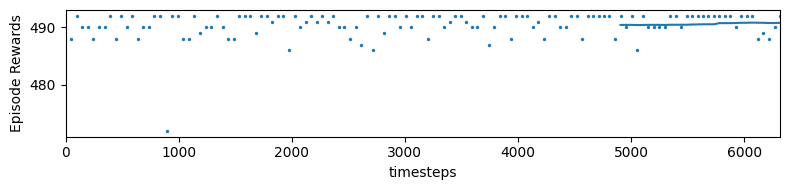

In [15]:
from stable_baselines3.common import results_plotter
# Helper from the library, a bit hard to read but immediately useable
results_plotter.plot_results(["log"], 1e7, results_plotter.X_TIMESTEPS,'')

In [16]:
#Load back the best model
model.set_parameters("log/best_model.zip")
from stable_baselines3.common.evaluation import evaluate_policy
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print("Best model's reward: %3.3g +/- %3.3g"%(mean_reward,std_reward))

Best model's reward: 492 +/-   0


Step 1 Action:  1 Tot. Reward: 3
Step 2 Action:  1 Tot. Reward: 6
Step 3 Action:  1 Tot. Reward: 9
Step 4 Action:  1 Tot. Reward: 12
Step 5 Action:  3 Tot. Reward: 10
Step 6 Action:  3 Tot. Reward: 8
Step 7 Action:  3 Tot. Reward: 6
Step 8 Action:  3 Tot. Reward: 4
Step 9 Action:  0 Tot. Reward: 2
Step 10 Action:  0 Tot. Reward: 0
Step 11 Action:  0 Tot. Reward: -2
Step 12 Action:  0 Tot. Reward: -4
Step 13 Action:  2 Tot. Reward: -1
Step 14 Action:  2 Tot. Reward: 2
Step 15 Action:  0 Tot. Reward: 0
Step 16 Action:  0 Tot. Reward: -2
Step 17 Action:  3 Tot. Reward: 1
Step 18 Action:  3 Tot. Reward: 4
Step 19 Action:  0 Tot. Reward: 2
Step 20 Action:  0 Tot. Reward: 0
Step 21 Action:  2 Tot. Reward: -2
Step 22 Action:  2 Tot. Reward: -4
Step 23 Action:  2 Tot. Reward: -6
Step 24 Action:  2 Tot. Reward: -8
Step 25 Action:  2 Tot. Reward: -10
Step 26 Action:  2 Tot. Reward: -12
Step 27 Action:  2 Tot. Reward: -14
Step 28 Action:  2 Tot. Reward: -16
Step 29 Action:  1 Tot. Reward: -18
Ste

MovieWriter ffmpeg unavailable; using Pillow instead.


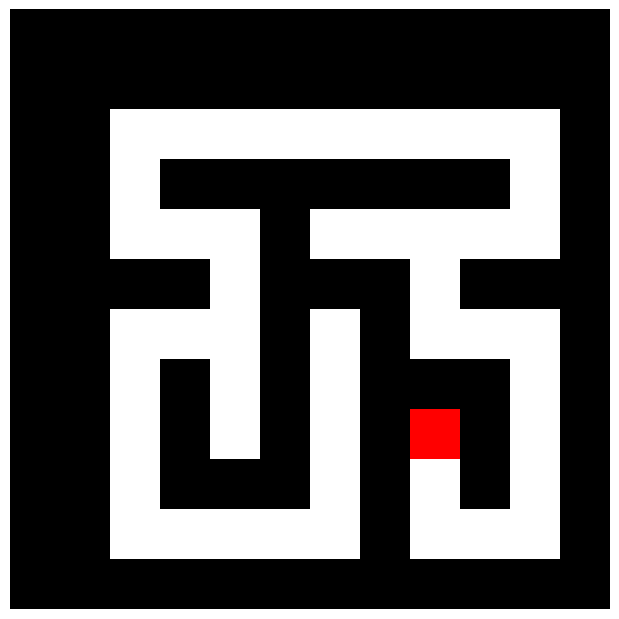

In [17]:
# Test the trained agent and save animation
obs, info = env.reset()
#Framework to save animgif
fig, ax = plt.subplots(figsize=(6,6))
plt.axis('off')
frames = []
fps=18

n_steps = 500
tot_reward = 0
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, truncate, info = env.step(action)
    tot_reward += reward
    print("Step {}".format(step + 1),"Action: ", action, 'Tot. Reward: %g'%(tot_reward))
    #print('position=', obs['position'], 'direction=', obs['direction'])
    #env.render(mode='console')
    frames.append([ax.imshow(env.render(), animated=True)])
    if done:
        print("Game over!", "tot. reward=", tot_reward)
        break
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box 
anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
anim.save("snake_best.gif",dpi=150)

In [18]:
#TESTING BLOCK

x = (np.array((6,6)) + (1,0)).astype(np.int32)
x

array([7, 6])